# Table of Contents


1. [Importing libraries](#importing-libraries)
2. [Creating the grid in real and $k$-spaces (in 2D)](#create)
3. [Defining the transfer function and the power spectrum](#define)
4. [Missing module 1. The Zel'dovich approximation: creating the displacement field](#za)
5. [Creating a function that calculates density field for the given spatial distiribution of particles](#create2)
6. [A simple example](#ex)
7. [Computing gradient of a potential field $\varphi(\mathbf{x})$](#comp)
8. [Calculating and plotting the force field for the given locations of particles in our example.](#calc)
9. [Missing module 2. Periodic boundary conditions](#pbc)
10. [Interpolation of fields](#interpolation)
11. [Parameters of the simulation and initial conditions](#para)
12. [Running the simulation](#run)
13. [Animation of the density field evolution](#ani)
14. [The resulting density field $\rho(\mathbf{x})$](#res)
15. [License](#license)

# Importing libraries <a name="importing-libraries"></a>

In [1]:
import numpy as np
from scipy import interpolate

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.animation as animation

from tqdm import tqdm_notebook as tqdm

# Creating the grid in real and $k$-spaces (in 2D) <a name="create"></a>

(100, 100)
(100, 51)


<IPython.core.display.Javascript object>


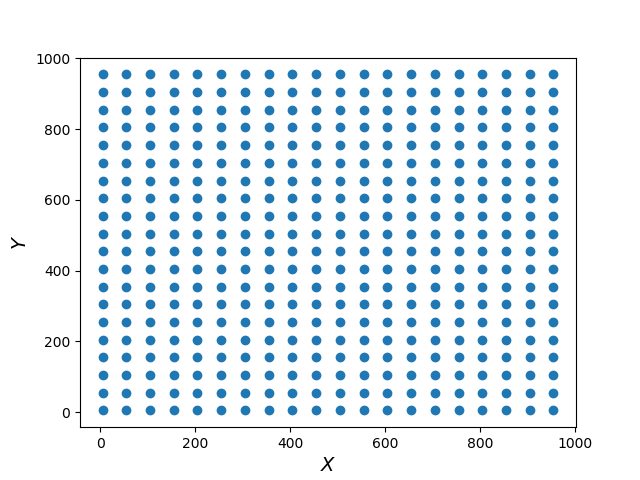

Text(0,0.5,'$Y$')

In [2]:
# grid parameters
N_grid = 100 # Number of grid points along each dimension

L_min = 0    # Min value of the box (each dimension)
L_max = 1000 # Max value of the box (each dimension)

L = L_max - L_min   # the total length of the box along each dimension
dL = L / N_grid     # spacing between two adjecent grid points

# creating grid in real space
x = np.linspace(L_min+dL/2, L_max-dL/2, N_grid)
y = np.linspace(L_min+dL/2, L_max-dL/2, N_grid)

x_grid, y_grid = np.meshgrid(x,y)

# creating grid in k-space
kx = 2 * np.pi * np.fft.rfftfreq(N_grid, d=dL)
ky = 2 * np.pi * np.fft.fftfreq(N_grid, d=dL)

kx_grid, ky_grid = np.meshgrid(kx,ky)

# calculating magnitudes of wavevectors at the grid points in k-space
k_total_grid = np.sqrt(kx_grid**2 + ky_grid**2)

# As we work only with real-valued fields (that is, not complex ones), the k-grid has half the number
# of points of the grid in real space.
print(np.shape(x_grid))
print(np.shape(kx_grid))

# plotting the created grid
plt.figure(1)
plt.scatter(x_grid[::5,::5],y_grid[::5,::5])
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)

# Defining the transfer function and the power spectrum <a name="define"></a>

In [3]:
# cosmological parameters for the transfer function
h = 0.7
Omega_m = 0.3
Gamma = h*Omega_m

# define the transfer function 
def Tk(k):
    '''Function to compute the transfer.
    The transfer function is defined by equation (8.75) in Peter Schneider's lecture notes.
    This corresponds to the transfer function given by Bardeen et. al (1986).
    
    Input:
    k: Comoving wavenumber
    
    Returns:
    transfer_function: Transfer function
    '''
    q = k/Gamma + 1e-15 # 1e-15 is added to avoid singularity at k = 0
    transfer_function = np.log( 1 + 2.34*q ) / 2.34 / q * ( 1 + 3.89*q + (16.1*q)**2 + (5.46*q)**3 + (6.71*q)**4 )**(-0.25)
    return transfer_function


<IPython.core.display.Javascript object>


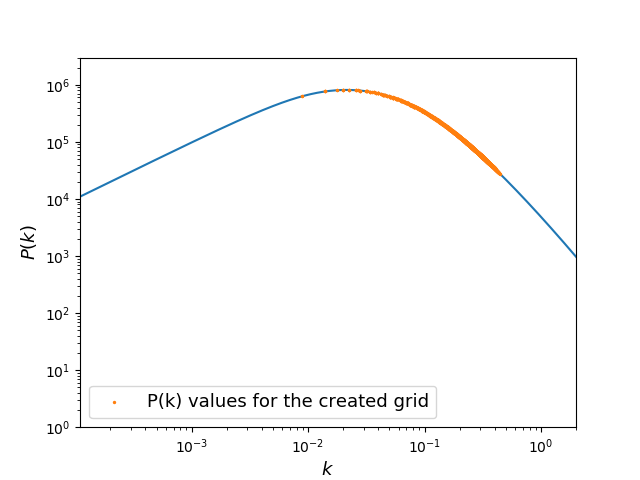

In [4]:
# creating the power spectrum P(k)
k = np.linspace(1e-4, 10, int(1e6)) # array of linearly spaced wavevector values
A = 1e8 # amplitude of the power spectrum (in code units)
P = A * Tk(k)**2 * k 

# the values of P(k) evaluated at the grid points
P_sim = A * Tk(k_total_grid)**2 * k_total_grid

# plotting P(k)
plt.figure(2)
plt.loglog(k, P)
plt.scatter(k_total_grid[1:,1:].flatten(), P_sim[1:,1:].flatten(),label='P(k) values for the created grid',s=2,color='C1',zorder=3)

plt.ylim(1,3*1e6)
plt.xlim(k[1],2)
plt.xlabel('$k$',fontsize=13)
plt.ylabel('$P(k)$',fontsize=13)

plt.legend(loc='lower left',fontsize=13)

# Missing module 1. The Zel'dovich approximation: creating the displacement field $\mathbf{f(q)}$ <a name="za"></a>

Use the equation written below to generate the displacement field $\mathbf{f}(\mathbf{q})$

$\displaystyle \mathbf{f(q)} = \int \mathrm{d}^3 k\ \exp(-i\mathbf{k}\mathbf{x})\thinspace \mathbf{f_k} = -\int \mathrm{d}^3 k  \   \exp(-i\mathbf{k}\mathbf{x}) \ i\frac{\delta_k}{k^2} \mathbf{k} $


where the Fourier modes of the density constrast field, $\delta_k$, are given by

$\displaystyle \delta_k = \sqrt{\frac{P(k)}{L^3}} \ \frac{a_k+ ib_k}{\sqrt{2}}$

with $a_k$ and $b_k$ being Gaussian random variables with unit variance and zero mean, so that

$\displaystyle \mathrm{Var}\left(\left|\delta_k\right|^2\right) = \frac{P(k)}{L^3}$

**Notes**:
- In this module, you need to generate the displacement field $\mathbf{f}(\mathbf{q})$

- You may need the function `np.random.normal(loc=mean, scale=sigma, size=N)` to compute $a_k$ and $b_k$

- For the inverse FFT use `np.fft.irfft2`. For an example, you can look at how this function is employed below in the code

- Note that in Python, you need to put 'j' after a real number to make it imaginary (e.g. 3j)

In [5]:
'''Here you add the module to generate f(q)
'''

'Here you add the module to generate f(q)\n'

# Creating a function that calculates density field for the given spatial distiribution of particles <a name="create2"></a>

In [6]:
def find_four_closest_points(x_point, y_point):
    '''Function to interpolate the particle mass to four nearest grid points
    
    Input:
    x_point: X-coordinate of the particles
    y_point: Y-coordinate of the particles
    
    Returns:
    rho_grid: The array containing the density field.
              Shape of the array is (N_cell*N_cell), where N_cell is the number
              of cells per dimension.
    '''
    rho_grid = np.zeros((N_grid, N_grid))
    
    for i in range(len(x_point)):
        x_arg = np.argmin(np.abs(x_point[i]-x))
        y_arg = np.argmin(np.abs(y_point[i]-y))
        
        if x_arg+1==N_grid:
            x_corr = 0
        else:
            x_corr = x_arg+1
            
        if y_arg+1==N_grid:
            y_corr = 0
        else:
            y_corr = y_arg+1
        
        dx_null  = (dL - np.abs(x_point[i]-x[x_arg]  )) / dL 
        dx_plus  = (dL -       (x[x_corr]-x_point[i])) / dL
        dx_minus = (dL -       (x_point[i]-x[x_arg-1])) / dL 
                    
        dy_null  = (dL - np.abs(y_point[i]-y[y_arg]  )) / dL 
        dy_plus  = (dL -       (y[y_corr]-y_point[i])) / dL
        dy_minus = (dL -       (y_point[i]-y[y_arg-1])) / dL 
        
        if np.abs(dx_plus)>=N_grid:
            dx_plus =  np.abs(dx_plus - N_grid) * np.sign(dx_plus) 
        if np.abs(dy_plus>=N_grid):
            dy_plus =  np.abs(dy_plus - N_grid) * np.sign(dy_plus) 
            
        if np.abs(dx_minus)>=N_grid:
            dx_minus = np.abs(dx_minus - N_grid) * np.sign(dx_minus) 
        if np.abs(dy_minus)>=N_grid:
            dy_minus = np.abs(dy_minus - N_grid) * np.sign(dy_minus) 
        
        rho_grid[y_arg,x_arg] += 1.0 * dx_null * dy_null
                    
        if (x_point[i]-x[x_arg])>0: 
            rho_grid[y_arg,x_corr] += 1.0 * dx_plus * dy_null
            if (y_point[i]-y[y_arg])>0:
                rho_grid[y_corr,x_arg]   += 1.0 * dx_null * dy_plus
                rho_grid[y_corr,x_corr] += 1.0 * dx_plus * dy_plus
            else:
                rho_grid[y_arg-1,x_arg]   += 1.0 * dx_null * dy_minus
                rho_grid[y_arg-1,x_corr] += 1.0 * dx_plus * dy_minus
        else:
            rho_grid[y_arg,x_arg-1] += 1.0 * dx_minus * dy_null
            if (y_point[i]-y[y_arg])>0:
                rho_grid[y_corr,x_arg]   += 1.0 * dx_null * dy_plus
                rho_grid[y_corr,x_arg-1] += 1.0 * dx_minus * dy_plus
            else:
                rho_grid[y_arg-1,x_arg] += 1.0 * dx_null * dy_minus
                rho_grid[y_arg-1,x_arg-1] += 1.0 * dx_minus * dy_minus  
                
    return rho_grid

# A simple example <a name="ex"></a>

Let us create 5 particles and compute their density field. Then compute the corresponding potential and force fields

<IPython.core.display.Javascript object>


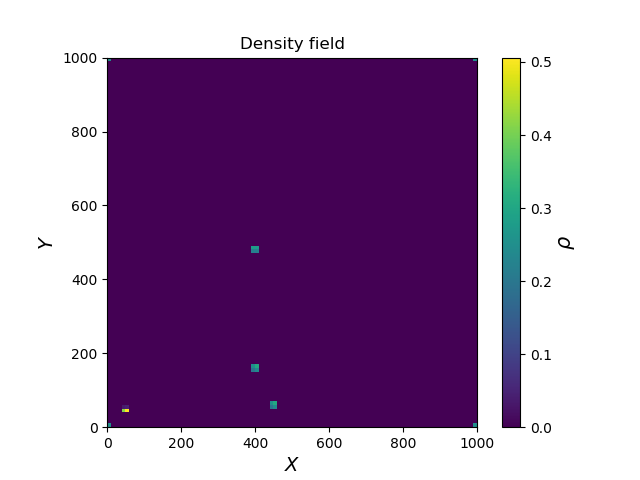

5.0


In [7]:
# particles' coordinates
x_points = np.array([0,50.5 ,450.5,400.5 ,400])
y_points = np.array([0,45.8,60.6, 160.6, 480.6])

# calculating the density field corresponding to the given distribution of particles of unit mass
rho_grid = find_four_closest_points(x_point=x_points,y_point=y_points)

# plotting the density field
plt.figure(3)
plt.imshow(rho_grid,extent=(L_min,L_max,L_min, L_max), origin='lower')
cbar = plt.colorbar()
cbar.set_label("$\\rho$", fontsize=15)
plt.title('Density field')
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
print(np.sum(rho_grid))

<IPython.core.display.Javascript object>


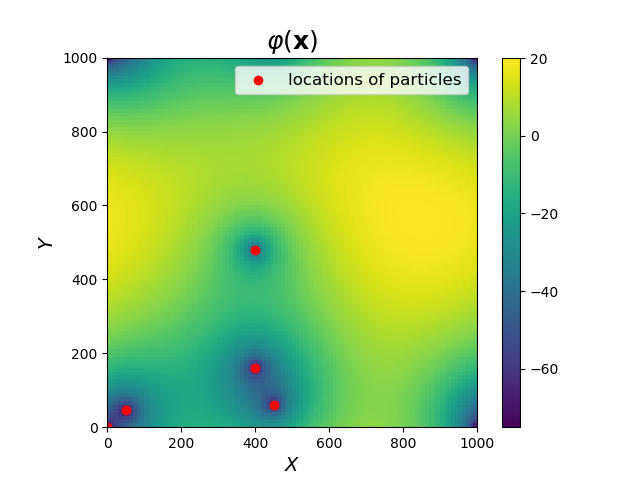

In [8]:
# solving the Poisson equation by doing forward and inverse FFT
rho_fft = np.fft.rfft2(rho_grid) # density field in Fourier space
phi_fft = -rho_fft / (1e-15 + kx_grid**2 + ky_grid**2) # potential field in Fourier space
phi_fft[0,0] = 1e-15 # 1e-15 is added here to avoid numerical singularities.
phi = np.fft.irfft2(phi_fft) # potential field in real space

plt.figure(4)
plt.imshow(phi,extent=(L_min,L_max,L_min, L_max), origin='lower')
plt.colorbar()
plt.scatter(x_points,y_points,color='red',label='locations of particles')
plt.title('$\\varphi (\\mathbf{x})$', fontsize=18)
plt.ylim(L_min,L_max)
plt.xlim(L_min,L_max)
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
plt.legend(loc='upper right',fontsize=12)

# Computing gradient of a potential field  $\varphi(\mathbf{x})$ <a name="comp"></a>

In [9]:
def grad_x(f):
    '''
    Function to compute the partial derivative of a given scalar field f with respect to X-coordinate
    
    Input: 
    f: scalar field
    
    Returns: 
    grad_f_x: the partial derivative of f with respect to X-coordinate
    '''
    grad_f_x = np.zeros_like(f)
        
    grad_f_x[:,1:-1] = (f[:,2:] - f[:,:-2])/dL/2
    grad_f_x[:,0]    = (f[:,1]  - f[:,-1]) /dL/2
    grad_f_x[:,-1]   = (f[:,0]  - f[:,-2]) /dL/2
    
    return grad_f_x


def grad_y(f):
    '''
    Function to compute the partial derivative of a given scalar field f with respect to Y-coordinate
    
    Input: 
    f: scalar field
    
    Returns: 
    grad_f_y: the partial derivative of f with respect to Y-coordinate
    '''
    grad_f_y = np.zeros_like(f)
    
    grad_f_y[1:-1,:] = (f[2:,:] - f[:-2,:])/dL/2
    grad_f_y[0,:]    = (f[1,:]  - f[-1,:]) /dL/2
    grad_f_y[-1,:]   = (f[0,:]  - f[-2,:]) /dL/2
    
    return grad_f_y



# Calculating and plotting the force field for the given locations of particles in our example. <a name="calc"></a>

<IPython.core.display.Javascript object>


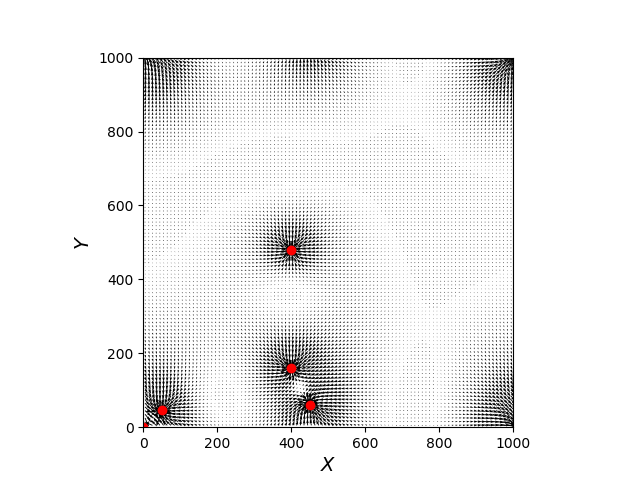

In [10]:
force_x_grid = -grad_x(phi)
force_y_grid = -grad_y(phi)
plt.figure(5)
plt.quiver(x_grid,y_grid,force_x_grid,force_y_grid)
plt.scatter(x_points,y_points,color='red')
plt.ylim(L_min,L_max)
plt.xlim(L_min,L_max)
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
plt.gca().set_aspect('equal')

# Missing module 2. Periodic boundary conditions <a name="pbc"></a>

- Create a function that takes account of the periodic boundary condition in the problem


- After the displacement if x-coordinate of a particle is larger than $L_\mathrm{max}$ or less than $L_\mathrm{max}$, then we invoke the periodicity such that the particle is bounded within the domain of the box, i.e $x \in [L_\mathrm{min}, L_\mathrm{max}]$.


- The same is true for its y-coordinate and should be taken care of accordingly.


- You can use simple conditional statements,

```if particle's x coordinate > L_max:
    particle's x coordinate -= L
if particle's y coordinate < L_min:
    particle's x coordinate += L```
 
 where, as we defined above, $L = L_\mathrm{max} - L_\mathrm{min}$. However, a more efficient way would be to use the function `np.where()`.

In [11]:
'''Here you write the function that accounts for the periodicitiy
'''

'Here you write the function that accounts for the periodicitiy\n'

# Interpolation of fields <a name="interpolation"></a>

- As the problem requires the force field and the displacement field evaluated at positions different from the grid vertices, we need some routine to interpolate the fields in between the grid vertices. 


- Namely, we make use of the scipy function `interpolate.LinearNDInterpolator`. In order to cover the whole box domain and have smooth transitions between the periodic boundaries, this functions requires the grid in real space extended by one extra layers of cell around the boundaries of the initial grid, which we have defined above.

In [12]:
# We first create the extended grid (extension of the initial grid) in real space
x_interp = np.linspace(L_min-dL/2, L_max+dL/2, N_grid+2)
y_interp = np.linspace(L_min-dL/2, L_max+dL/2, N_grid+2)
x_grid_interp, y_grid_interp = np.meshgrid(x_interp,y_interp)

# As an input parameter the interpolatoin function, that we use, requires the grid shaped into this form.
p = np.vstack([y_grid_interp.flatten(), x_grid_interp.flatten()]).T 

# If we extend the coordinate grid, we also need to extend the fields evaluated at the extended grid's points. 
# The function below does the latter for us.
def periodic_extension(field):
    '''Function to add padding layer as to account for periodicity while interpolating the required fields.
    
    Input: 
    field: any real-valued field evaluated at the verticies of the initial grid in real space
    
    Returns: 
    field_extended: periodic extension of the field by one extra layer of cells around the boundaries of
                    the initial grid
    
    Examples:
    3x3 matrix  1 2 3
                4 5 6
                7 8 9
    For the provided exampled the output has the form
                9 7 8 9 7
                3 1 2 3 1
                6 4 5 6 4
                9 7 8 9 7
                3 1 2 3 1
    '''
    field_extended = np.zeros(np.shape(field)+np.array((2,2)))
    
    field_extended[1:-1,1:-1] = field
    
    for i,j in zip([0,-1],[-1,0]):
        field_extended[i,1:-1]  = field[j,:]
        field_extended[1:-1,i]  = field[:,j]
        field_extended[i,i]     = field[j,j]
        field_extended[i,j]     = field[j,i]
    
    return field_extended

# Parameters of the simulation and initial conditions  <a name="para"></a>

<IPython.core.display.Javascript object>


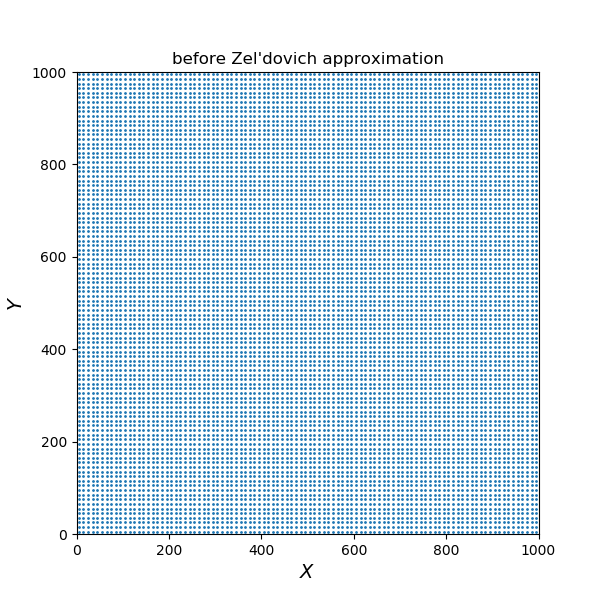

In [13]:
G = 0.01         # strength of gravity (in code units)
N_points= 100**2 # number of particles
N_steps = 100    # number of time steps
n = 0            # counter for the while loop below
dt = 0.3         # time step

# arrays in which all the snapshots of particles' positions will be saved. 
# We will use these to create an animation of the density field evolution.
x_points_all = np.zeros((N_points,N_steps+1))
y_points_all = np.zeros((N_points,N_steps+1))

# Creating particles
x_points_grid = np.linspace(L_min+(0.5*dL), L_max-(0.5*dL),int(np.sqrt(N_points)))
y_points_grid = np.linspace(L_min+(0.5*dL), L_max-(0.5*dL),int(np.sqrt(N_points)))
x_points_grid,y_points_grid = np.meshgrid(x_points_grid, y_points_grid)

# coordinates of the particles
x_points = x_points_grid.flatten()
y_points = y_points_grid.flatten()

# velocities of the particles
vel_x = np.zeros(N_points)
vel_y = np.zeros(N_points)

# computing the density field that corresponds to the initial distribution of particles
rho_grid = find_four_closest_points(x_point=x_points,y_point=y_points)

# plotting the initial distribution of particles
plt.figure(7, figsize=(6,6))
plt.scatter(y_points,x_points,color='C0',s=1,zorder=3)
plt.xlim(L_min,L_max)
plt.ylim(L_min,L_max)
plt.title('before Zel\'dovich approximation')
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
plt.gca().set_aspect('equal')

<IPython.core.display.Javascript object>


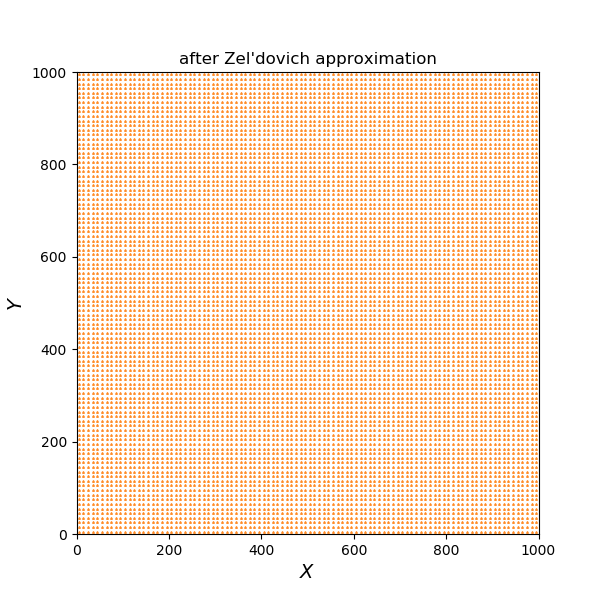

In [14]:
'''

!!!

Here shift the initial particles' coordinate according to the Zel'dovich approximation.
Don't forget to account for the periodic boundary conditions after you have shifted the particles
(by calling the periodic boundary condition function you wrote above).

!!!

'''

# saving the initial snapshot for the animation of the density field that we will create later
x_points_all[:,0] = x_points
y_points_all[:,0] = y_points

# the updated density field
rho_grid = find_four_closest_points(x_points, y_points)

# plotting the new distribution of particles after the Zel'dovich approximation has been applied
plt.figure(8, figsize=(6,6))
plt.xlim(L_min,L_max)
plt.ylim(L_min,L_max)
plt.scatter(y_points,x_points,color='C1',s=1, marker='^',zorder=3) 
plt.title('after Zel\'dovich approximation')
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
plt.gca().set_aspect('equal')

# Running the simulation <a name="run"></a>

In [15]:
# running the simulation

with tqdm(total=N_steps) as pbar:
    while n<N_steps:

        n+=1 # updating counter

        rho_fft = np.fft.rfft2(rho_grid) # density field in k-space
        phi_fft = -rho_fft / (1e-15 + kx_grid**2 + ky_grid**2) * G # potential field in k-space
        phi = np.fft.irfft2(phi_fft) # potential field in real space
        
        # force evaluated at vertices of the initial grid
        force_x_grid = -grad_x(phi)
        force_y_grid = -grad_y(phi)
        
        # here we extend the force field by adding one extra layer of cells around boundaries of the initial grid
        force_x_grid_extended =  periodic_extension(force_x_grid)
        force_y_grid_extended =  periodic_extension(force_y_grid)
        
        # interpolating the extended force field over the extended grid
        force_x = interpolate.LinearNDInterpolator(p, force_x_grid_extended.flatten())
        force_y = interpolate.LinearNDInterpolator(p, force_y_grid_extended.flatten())

        # updating velocities
        vel_x += force_x(y_points,x_points) * dt 
        vel_y += force_y(y_points,x_points) * dt 
        
        dx = vel_x * dt
        dy = vel_y * dt
        
        # updating particle coordinates
        x_points += dx
        y_points += dy

        '''
        
        !!!!
        
        Make sure you call the function that accounts for the periodic boundary conditions to keep all the particles 
        bounded within the box domain.
        
        !!!!
        
        ''' 

        # saving particles' coordinates at each time step for the animation that we will make later
        x_points_all[:,n] = x_points
        y_points_all[:,n] = y_points

        # creating the density field corresponding to the updated particles' positions
        rho_grid = find_four_closest_points(x_points, y_points)
        
        pbar.set_description('processed: %d' % (1))
        pbar.update(1)

# Animation of the density field evolution <a name="ani"></a>

<IPython.core.display.Javascript object>


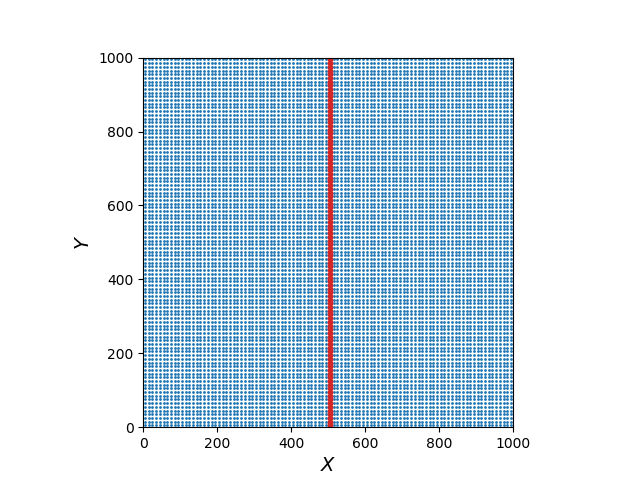

In [16]:
fig = plt.figure(9)
ax = plt.axes(xlim=(L_min-100, L_max+100), ylim=(L_min-100, L_max+100))
scat = ax.scatter([], [], s=1)
scat1 = ax.scatter([], [], s=10, c='C3')
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel("$X$", fontsize=14)
plt.ylabel("$Y$", fontsize=14)
plt.gca().set_aspect('equal')

def animate(i): 
    global x_points_all, y_points_all
    
    data = np.hstack((x_points_all[:,i,np.newaxis], y_points_all[:, i,np.newaxis]))
    data1 = np.hstack((x_points_all[50::100,i,np.newaxis], y_points_all[50::100, i,np.newaxis]))
    scat.set_offsets(data)
    scat1.set_offsets(data1)
    return scat, scat1,

anim = animation.FuncAnimation(fig, animate, frames=(N_steps), 
                               interval=100, blit=False, repeat=True)

# The resulting density field $\rho(\mathbf{x})$ <a name="res"></a>

- Plot the evolved density field (you may need the function `plt.imshow()`)

# The end

# License <a name="license"></a>


This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.